Fraud Detection in Transaction Data using Isolation Forest

In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyanshijoshi","key":"e3fddbd9418060df4046612979f5e208"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 99% 65.0M/66.0M [00:03<00:00, 30.7MB/s]
100% 66.0M/66.0M [00:03<00:00, 22.5MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('creditcardfraud.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [6]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [8]:
def ztest(feature):

    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))

    return zScore

In [9]:
columns= df.drop('Class', axis=1).columns
normal= df[df.Class==0]
fraud= df[df.Class==1]
sample_size=len(fraud)
significant_features=[]
critical_value=2.58

for i in columns:

    z_vavlue=ztest(i)

    if( abs(z_vavlue) >= critical_value):
        significant_features.append(i)

In [10]:
significant_features.append('Class')
df= df[significant_features]

inliers = df[df.Class==0]
ins = inliers.drop(['Class'], axis=1)

outliers = df[df.Class==1]
outs = outliers.drop(['Class'], axis=1)

ins.shape, outs.shape

((284315, 23), (492, 23))

In [11]:
def normal_accuracy(values):

    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)

    return accuracy

def fraud_accuracy(values):

    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)

    return accuracy

In [12]:
state= 42

ISF = IsolationForest(random_state=state)
ISF.fit(ins)

normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)

in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)
print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf)

Accuracy in Detecting Normal Cases: 0.9561
Accuracy in Detecting Fraud Cases: 0.8496


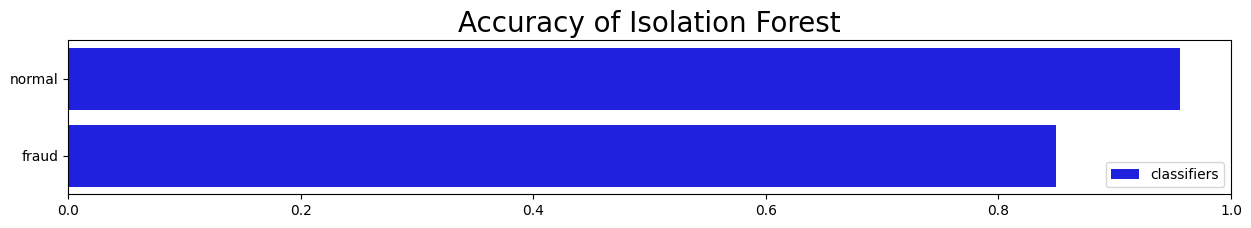

In [16]:
fig, ax1= plt.subplots(1, figsize=[15,2])

ax1.set_title("Accuracy of Isolation Forest",fontsize=20)
sns.barplot(x=[in_accuracy_isf,out_accuracy_isf],
            y=['normal', 'fraud'],
            label="classifiers",
            color="b",
            ax=ax1)
ax1.set(xlim=(0,1))
plt.show()